In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

In [2]:
proposal_probs = {"grow" : 0.5,
                  "prune" : 0.5}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
np.set_printoptions(suppress=True)
print(y_train[:12])

[ 0.50327821  0.60672224  0.26898966  0.55211673  0.50693811  0.66162097
 -0.64127659  0.65112284  0.03487759  0.23276531  0.44055996  0.38216964]


In [3]:
#profiler = Profiler()
#profiler.start()
ndpost = 10000
bart = ChangeNumTreeBART(ndpost=ndpost, nskip=10000, n_trees=200, proposal_probs=proposal_probs)
bart.fit(X_train, y_train)
#profiler.stop()
#profiler.print()

Iterations: 100%|██████████| 20000/20000 [02:08<00:00, 155.36it/s]


In [4]:
bart.trace[-1].n_trees

53

In [5]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace[-ndpost:]]

# n_trees_list now contains the n_trees values for the last 500 instances
print(n_trees_list)

[47, 48, 49, 49, 49, 49, 48, 48, 48, 48, 48, 47, 47, 48, 48, 48, 49, 50, 50, 50, 50, 50, 51, 50, 50, 50, 50, 50, 51, 52, 53, 53, 53, 53, 53, 53, 54, 54, 53, 53, 53, 54, 54, 54, 53, 52, 52, 51, 51, 51, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 55, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 53, 53, 53, 54, 54, 54, 53, 53, 53, 52, 51, 52, 52, 53, 52, 51, 51, 51, 51, 51, 51, 51, 51, 51, 50, 50, 50, 50, 50, 50, 50, 49, 49, 49, 49, 49, 48, 49, 50, 51, 51, 52, 52, 52, 52, 51, 51, 52, 52, 52, 52, 52, 53, 52, 52, 52, 52, 51, 51, 51, 51, 51, 52, 51, 50, 51, 51, 52, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 52, 53, 53, 53, 54, 54, 53, 53, 52, 51, 51, 51, 51, 51, 50, 51, 51, 50, 50, 49, 49, 49, 49, 49, 49, 48, 48, 48, 48, 48, 47, 48, 47, 47, 47, 47, 47, 47, 47, 48, 47, 47, 48, 48, 47, 47, 47, 48, 48, 48, 49, 50, 50, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 49, 49, 48, 47, 47, 46, 46, 46, 46, 47, 47, 47, 47, 46, 46,

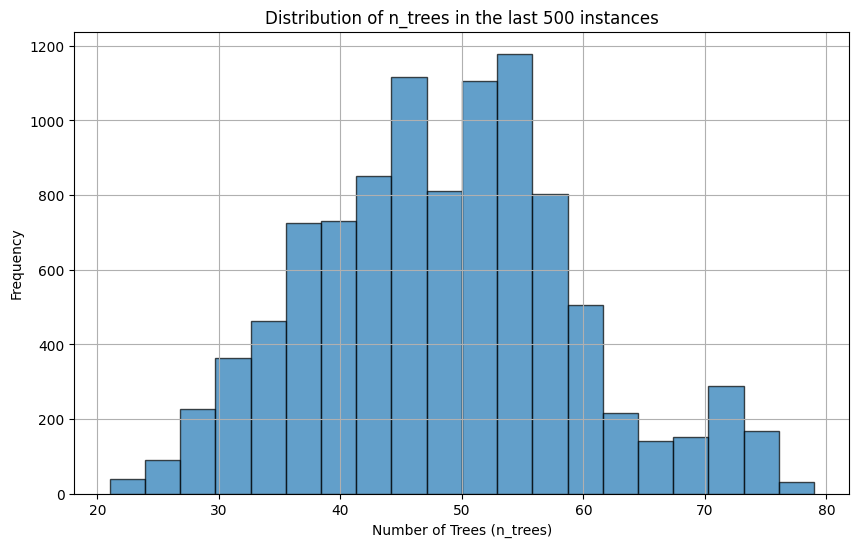

In [6]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the last 500 instances')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

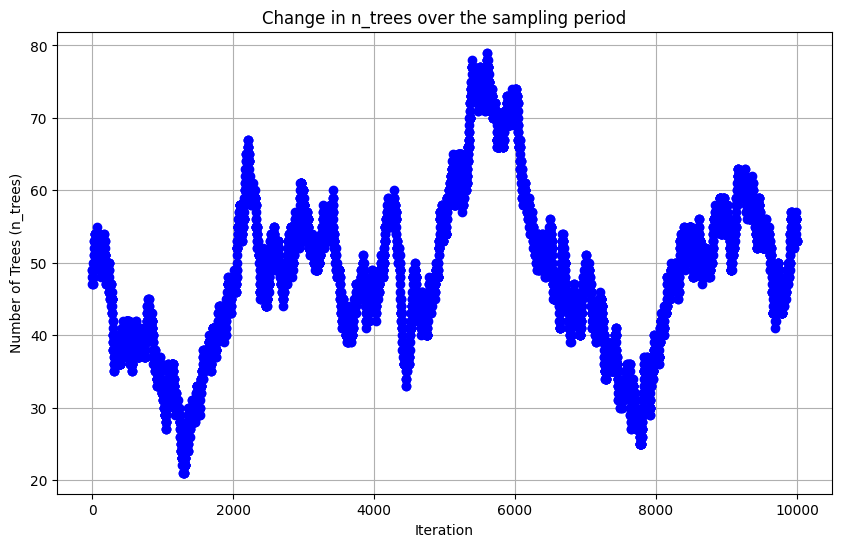

In [7]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(n_trees_list)), n_trees_list, marker='o', linestyle='-', color='b')
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [8]:
bart.trace[-1].trees

[Tree(vars=[ 0  0 -1 -1 -1 -2 -2 -2], thresholds=[0.37508165 0.26331385        nan        nan        nan        nan
         nan        nan], leaf_vals=[       nan        nan 0.00688168 0.00840418 0.02259126        nan
         nan        nan], n_vals=[120  52  68  36  16  -2  -2  -2]),
 Tree(vars=[-1 -2], thresholds=[nan nan], leaf_vals=[0.00160786        nan], n_vals=[120  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.14161164        nan        nan        nan], leaf_vals=[       nan 0.00095808 0.00782742        nan], n_vals=[120  21  99  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.36456051        nan        nan        nan], leaf_vals=[        nan -0.03010128 -0.02014434         nan], n_vals=[120  48  72  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.37508165        nan        nan        nan], leaf_vals=[       nan 0.00223552 0.01505302        nan], n_vals=[120  52  68  -2]),
 Tree(vars=[ 0 -1 -1 -2], thresholds=[0.92718166        nan        nan        nan], leaf_vals=[        nan  

In [9]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-03-25 17:29:18,100:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-03-25 17:29:18,104:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.53 P_prune=0.47 A_grow=0.39 A_prune=0.24 (burnin)
Iteration 200/300 P_grow=0.45 P_prune=0.55 A_grow=0.50 A_prune=0.55
Iteration 300/300 P_grow=0.47 P_prune=0.53 A_grow=0.16 A_prune=0.39


In [10]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.18710558208181607,
 'rf': 0.02011419957538542,
 'lr': 0.048045521328019404,
 'btz': 0.02291858266658004}